---
### Predict Future Sales
##### - Final project for "How to win a data science competition" Coursera course
> - 2013.01 ~ 2015.10 / 16,627 Teams applied   
> - 일별 판매내역을 기반으로 2015년 11월의 각 상점별 상품별 월간 판매량 예측
> - Target값은 0~20개 사이로 제한 (20개를 넘으면 20으로 간주)
> - 평가기준 = RMSE /  제출양식 = ID,item_cnt_month (0,0.5) (1,0.5) (2,0.5) ... 
> - https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales
---

- File descriptions  
    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.   
    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.   
    sample_submission.csv - a sample submission file in the correct format.  
    items.csv - supplemental information about the items/products.  
    item_categories.csv  - supplemental information about the items categories.  
    shops.csv- supplemental information about the shops.  
  
- Data fields  
    ID - an Id that represents a (Shop, Item) tuple within the test set  
    shop_id - unique identifier of a shop  
    item_id - unique identifier of a product  
    item_category_id - unique identifier of item category  
    item_cnt_day - number of products sold. You are predicting a monthly amount of this measure  
    item_price - current price of an item  
    date - date in format dd/mm/yyyy  
    date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33  
    item_name - name of item  
    shop_name - name of shop  
    item_category_name - name of item category  

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel", 
              rc={"font.size": 9, "axes.titlesize": 9, "axes.labelsize": 9,
              "xtick.labelsize": 9, "ytick.labelsize": 9})  

#data loading
data_path = 'kaggle/input/competitive-data-science-predict-future-sales/'
sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

--- 
#### Data Review

In [2]:
print(sales_train.shape)
sales_train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
sales_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


- date_block_num : 월 구분자. 0 = 2013.01월, 1 = 2013.02월, ... , 33 = 2015.10월 
- 목적은 월 판매량 구하기이므로, date_block_num 기준 그룹화하여 shop_id & item_id별 item_cnt_day의 합계를 구한다. 
- 데이터에 결측치는 없다. 

In [4]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
shops.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


- 총 60개의 상점이름 (러시아어), 결측값은 없다. 

In [7]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
items.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


- 총 22170개의 상품명, 결측치 없음 

In [9]:
print(item_categories.shape)
item_categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
item_categories.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


- 상품카테고리는 총 84개, 결측값 없음 

In [11]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


---
##### 데이터 결합하고, 변수 요약표 만들기  
- train = sales_train + shops + items + item_categories 

In [12]:
#데이터 결합 
train = sales_train.merge(shops, on = 'shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [13]:
#변수요약 함수 
def resumetable(df) : 
    print(f'Dataset Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['Data_type'])
    summary = summary.reset_index()
    summary = summary.rename(columns = {'index':'feature'})
    summary['Num_of_NA'] = df.isnull().sum().values
    summary['Num_of_Unique'] = df.nunique().values
    summary['1st Value'] = df.loc[0].values
    summary['2nd Value'] = df.loc[1].values

    return summary 

In [14]:
resumetable(train)

Dataset Shape: (2935849, 10)


,feature,Data_type,Num_of_NA,Num_of_Unique,1st Value,2nd Value
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


---
#### 시각화 

Text(0.5, 1.0, 'Boxplot of item_price')

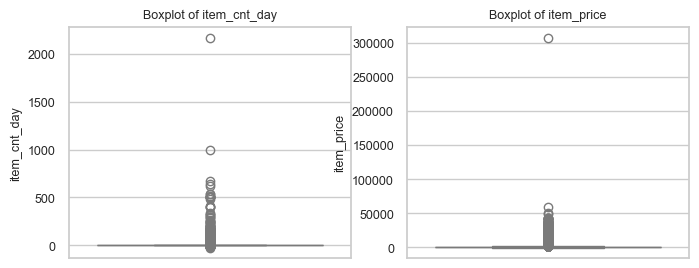

In [16]:
#판매량과 가격 시각화 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.boxplot(data=train, y='item_cnt_day', ax=ax1)
sns.boxplot(data=train, y='item_price', ax=ax2)

ax1.set_title('Boxplot of item_cnt_day')
ax2.set_title('Boxplot of item_price')

- outlier 처리가 필요하다. 

<Axes: xlabel='date_block_num', ylabel='item_cnt_day'>

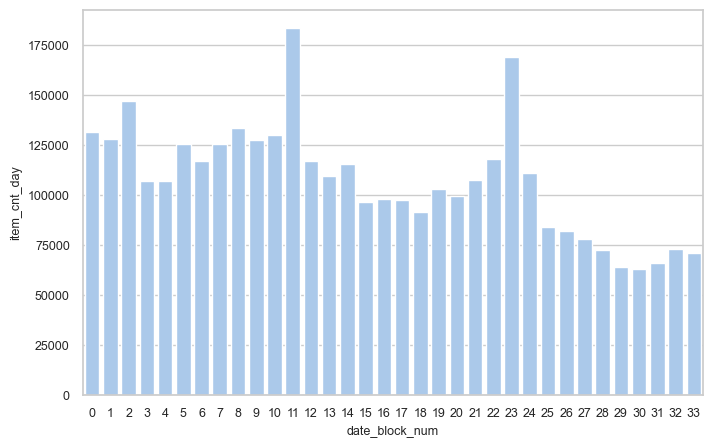

In [19]:
#groupby() 활용 --> 월별 판매량 합계 계산 
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day':'sum'})
group_month_sum = group_month_sum.reset_index()

plt.figure(figsize = (8,5))
sns.barplot(data=group_month_sum, x='date_block_num', y='item_cnt_day')

<Axes: xlabel='item_category_id', ylabel='item_cnt_day'>

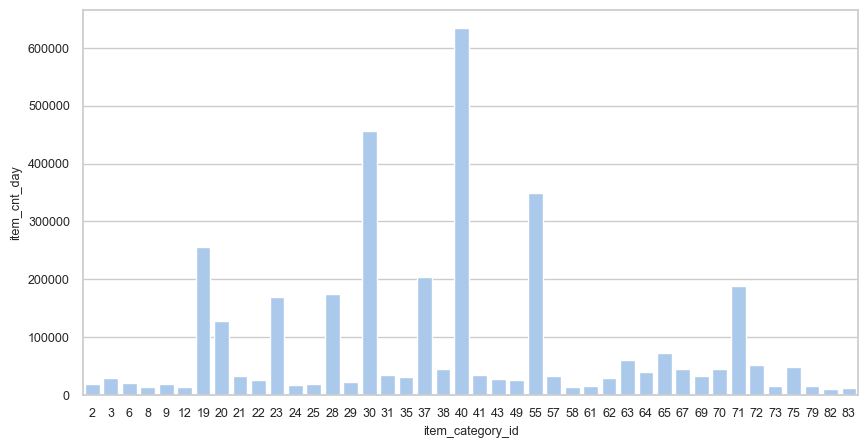

In [26]:
#상품 카테고리별 판매량 (카테고리 = 84개, 판매량 > 10000 이상인 것만)
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day':'sum'})
group_cat_sum = group_cat_sum.reset_index()
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

plt.figure(figsize = (10,5))
sns.barplot(data=group_cat_sum, x='item_category_id', y='item_cnt_day') 

<Axes: xlabel='shop_id', ylabel='item_cnt_day'>

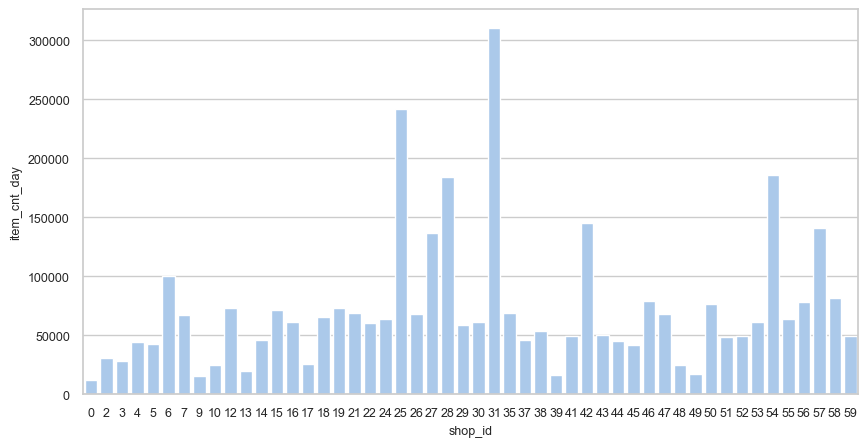

In [29]:
#상점별 판매량 (shop_id = 214200개, 판매량 > 10000 이상인 것만)
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day':'sum'})
group_shop_sum = group_shop_sum.reset_index()
group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

plt.figure(figsize = (10,5))
sns.barplot(data=group_shop_sum, x='shop_id', y='item_cnt_day') 

#### 결론 
- item_cnt_day, item_price 변수에 outlier 발견 
- [배경정보] shop_name, item_category_name의 첫 단어는 각각 '도시'와 '대분류'를 의미함 --> 파생변수 생성/추가 검토  